In [11]:
import numpy as np
import pandas as pd
import os, sys
from dtaidistance import dtw
from tqdm import tqdm
sys.path.append('..')
from scipy.ndimage.filters import gaussian_filter1d
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
from dgan.dgan import DGAN
import glob
import plot
import random

from sklearn.preprocessing import normalize
from sklearn.preprocessing import minmax_scale
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances_chunked

def calculate_energy_score(probs_for_sample, samples, correct_profile):
    """
        samples: 2d numpy array shape (#samples, #dim) , rows are predicted samples
        probs_for_sample: 1d numpy array shape (#samples), for each sample in samples the probability that it will get sampled
        correct_profile: 1d numpy array shape (#dim), the ground truth sample
    """
    def reduce_function(chunk, start):
        sums = (chunk * probs_for_sample).sum(axis = 1)
        return sums*probs_for_sample[start:start + sums.shape[0]]

    # because the full distance array gets very very large (GB's), process the chunks seperately into the needed sum
    second_term = 0
    for chunk in pairwise_distances_chunked(samples, reduce_func = reduce_function):
        second_term += chunk.sum(axis = None)
    distances_between_test_and_training_days = euclidean_distances(samples, correct_profile.reshape((1, -1))).squeeze()
    
    first_term = np.sum(probs_for_sample * distances_between_test_and_training_days)

    return first_term - 0.5*second_term

#This notebook calculates the enerygscore for a training run for every x epochs

C:\Users\jankr\AppData\Local\Temp\ipykernel_9772\366167024.py:7: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
scores = []
energy_scores7 = []
energy_scores8 = []
energy_scores9 = []


In [1]:
dir = '../../runs/run7/*.pt'
models =  glob.glob(dir)

data = np.load('../../data/train/dataset.npz', allow_pickle=True)
data_feature = np.array(data['f'], dtype=object)[:40]
data_feature_2d = np.reshape(data_feature,(len(data_feature),len(data_feature[0])))
data_feature_norm_mm = minmax_scale(data_feature_2d, axis=1).astype('double')

for i in tqdm(range(0,30_000,400)):
    gan = DGAN.load(f'../../runs/run7/model{i}.pt')
    _, synthetic_features = gan.generate_numpy(100)
    synthetic_features_2d = np.reshape(synthetic_features,(len(synthetic_features),len(synthetic_features[0])))
    synthetic_features_norm = minmax_scale(synthetic_features_2d, axis=1).astype('double')

    #Calculate energy scores
    scores = []
    data_feature_norm_mm_shuffled = random.shuffle(data_feature_norm_mm)
    for idx, data in enumerate(data_feature_norm_mm[:2500]):
        scores.append(calculate_energy_score([1/2500]*2500, synthetic_features_2d, data))
    energy_scores1.append(np.mean(scores))

NameError: name 'glob' is not defined

In [90]:
energy_scores = energy_scores[1:]

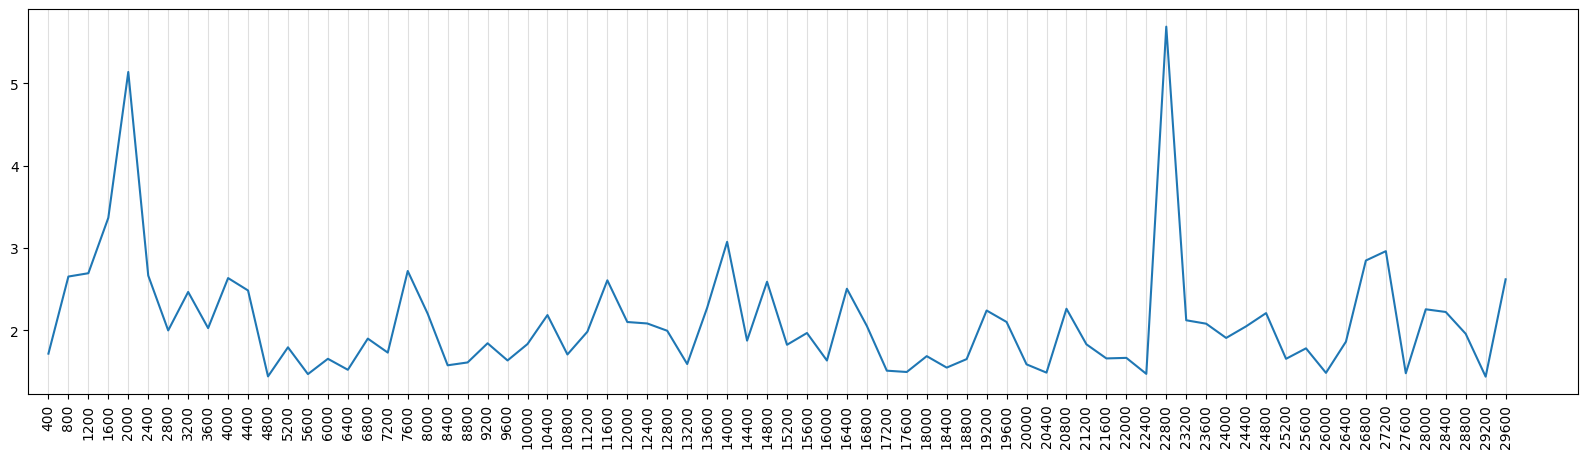

In [91]:
# 
# ysmoothed = gaussian_filter1d(np.array(energy_scores,dtype=np.float64), sigma=1)
x = range(1,len(energy_scores)+1)
plt.figure(figsize=(20,5))
plt.plot(x, energy_scores)
plt.xticks(x, range(400,30_000,400),minor=False, rotation=90)
plt.xlim(0)
plt.grid(True, axis="x", alpha=0.4)
plt.show()
# plt.yscale('log')
# plt.plot(np.reshape(synthetic_features,(len(synthetic_features),96))[0])